In [1]:
%env PYTHONPATH=~/repos/data2vec

env: PYTHONPATH=~/repos/data2vec


In [2]:
%env CUDA_VISIBLE_DEVICES=0
%env OMP_NUM_THREADS=8
%env OPENBLAS_NUM_THREADS=8

env: CUDA_VISIBLE_DEVICES=0
env: OMP_NUM_THREADS=8
env: OPENBLAS_NUM_THREADS=8


In [3]:
from data_processing import build_data2vec_dataset
from model_and_data_args import DataTrainingArguments, ModelArguments

### BEiT masking
---

In [4]:
model_args = ModelArguments(image_size=224, patch_size=16)
data_args = DataTrainingArguments(masking_strategy='beit', 
                                  mask_ratio=0.6, mask_patch_size=16, dataset_class="ImageFolder")

dataset = build_data2vec_dataset("/mnt/data/imagenet/train", data_args, model_args)

In [5]:
data, label = dataset[0]
img = data["pixel_values"]
mask = data["mask"]

In [6]:
img.shape, mask.shape

(torch.Size([3, 224, 224]), torch.Size([196]))

In [7]:
import torch

a = torch.randn(12, 12)
torch.allclose(a, a.flatten().reshape(12, 12))

True

In [8]:
mask.reshape(14, 14)

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0]])

In [9]:
def token_mask_to_img_mask(mask):
    return mask.reshape(14, 14).repeat_interleave(16, dim=0).repeat_interleave(16, dim=1)

big_mask = token_mask_to_img_mask(mask)

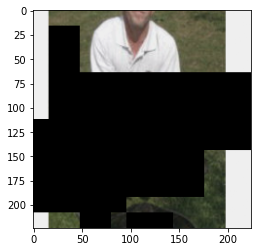

In [10]:
import matplotlib.pyplot as plt 


IMAGENET_MEAN = torch.Tensor([0.485, 0.456, 0.406]).reshape(3,1,1)
IMAGENET_STD = torch.Tensor([0.229, 0.224, 0.225]).reshape(3,1,1)

img = img * IMAGENET_STD + IMAGENET_MEAN


plt.imshow(img.permute(1, 2, 0) *(1 - big_mask.unsqueeze(2)))

In [11]:
from torchvision.utils import make_grid

In [12]:
imgs = []
masked_imgs = []

for i, (data, label) in enumerate(dataset):
    img = data["pixel_values"]
    mask = data["mask"]
    
    img = img * IMAGENET_STD + IMAGENET_MEAN
    
    big_mask = token_mask_to_img_mask(mask)
    
    imgs.append(img)
    masked_imgs.append(img * (1 - big_mask.unsqueeze(0)))
    
    if i >= 15:
        break

imgs = make_grid(torch.stack(imgs), nrow=4).permute(1,2,0)
masked_imgs = make_grid(torch.stack(masked_imgs), nrow=4).permute(1,2,0)

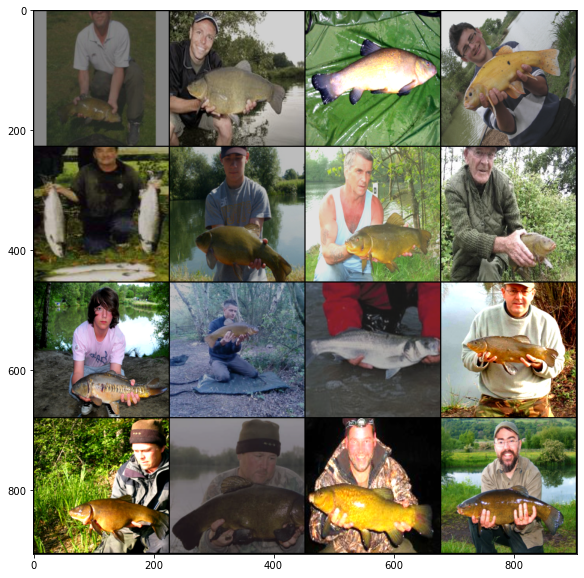

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(imgs)

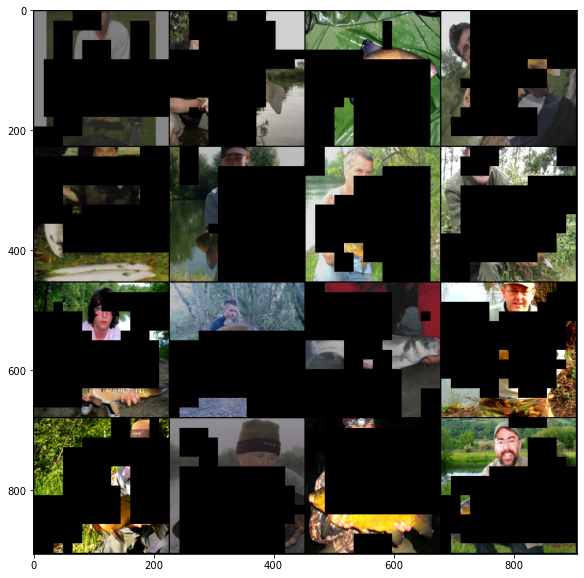

In [14]:
plt.figure(figsize=(10, 10))
plt.imshow(masked_imgs)

In [15]:
from data2vec_model import ViTForData2Vec, ViTConfigForData2Vec

In [16]:
config = ViTConfigForData2Vec(n_layers_to_average=8, huber_loss_delta=2., num_attention_heads=8)
config

ViTConfigForData2Vec {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "huber_loss_delta": 2.0,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "n_layers_to_average": 8,
  "num_attention_heads": 8,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.18.0.dev0"
}

In [17]:
model = ViTForData2Vec(config)

In [18]:
output = model(img.unsqueeze(0), output_hidden_states=True)
len(output.student_hidden_states)

13

In [19]:
for i in range(len(output.student_hidden_states)):
    print(output.student_hidden_states[i].shape)

torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


In [20]:
output = model(img.unsqueeze(0), output_attentions=True)
len(output.student_attentions)

12

In [21]:
for i in range(len(output.student_attentions)):
    print(output.student_attentions[i].shape)

torch.Size([1, 8, 197, 197])
torch.Size([1, 8, 197, 197])
torch.Size([1, 8, 197, 197])
torch.Size([1, 8, 197, 197])
torch.Size([1, 8, 197, 197])
torch.Size([1, 8, 197, 197])
torch.Size([1, 8, 197, 197])
torch.Size([1, 8, 197, 197])
torch.Size([1, 8, 197, 197])
torch.Size([1, 8, 197, 197])
torch.Size([1, 8, 197, 197])
torch.Size([1, 8, 197, 197])


In [22]:
for i in range(len(output.teacher_attentions)):
    print(output.teacher_attentions[i].shape)

torch.Size([1, 8, 197, 197])
torch.Size([1, 8, 197, 197])
torch.Size([1, 8, 197, 197])
torch.Size([1, 8, 197, 197])
torch.Size([1, 8, 197, 197])
torch.Size([1, 8, 197, 197])
torch.Size([1, 8, 197, 197])
torch.Size([1, 8, 197, 197])
torch.Size([1, 8, 197, 197])
torch.Size([1, 8, 197, 197])
torch.Size([1, 8, 197, 197])
torch.Size([1, 8, 197, 197])
